In [ ]:
def next_state(alive_n, ambiguous_n, center):
    if center == 2: 
        if alive_n == 3 and ambiguous_n == 0:
            return 1
        if alive_n > 3:
            return 0
        if alive_n + ambiguous_n < 2:
            return 0
        return 2

    neighbours = set(range(alive_n, alive_n + ambiguous_n + 1))
    if center == 0:
        target = {3}
    else:
        target = {2,3}

    if neighbours.isdisjoint(target):
        return 0
    if neighbours <= target:
        return 1
        
    return 2

# rules = []

# for target_state in (0,1,2):
#     for c1 in range(9):
#         for c2 in range(9):
#             if c1 + c2 > 8: continue
#             out = next_state(c1, c2, target_state)
#             r = [target_state,]
#             for i in range(c1): r.append(1)
#             for i in range(c2): r.append(2)
#             for i in range(8 - c1 - c2):  r.append(0)
#             r.append( out )
#             r = ','.join(map(str, r))
#             rules.append(r)

# for i in rules:
#     print(i)

In [ ]:
import numpy as np
from math import floor

def near(a, b):
    yield (a, b+1)
    yield (a+1, b)
    yield (a, b-1)
    yield (a-1, b)
    yield (a+1, b+1)
    yield (a-1, b+1)
    yield (a+1, b-1)
    yield (a-1, b-1)


def gen_noisy_block(start_block, n_layer = 0, corruption_per = 0.03):
    area = start_block.shape[0]*start_block.shape[1]
    to_corrupt = int(area*corruption_per)
    
    new_block = np.zeros(start_block.shape[:1], dtype=int)
    new_block = start_block[:,:,n_layer].copy()

    indices = np.random.choice(new_block.shape[1]*new_block.shape[0], replace=False, size=to_corrupt)

    new_block[np.unravel_index(indices, new_block.shape)] = 100 

    full_block = np.zeros(start_block.shape, dtype=int)
    full_block[:,:,0] = new_block

    return full_block

to_small_val = lambda t: 2 if t == 100 else t

def update_ambigous_block(arr):
    from scipy.signal import convolve2d
    tr = arr.shape
    iters = arr.shape[2]

    scharr = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=int)
    
    for i in range(iters-1):

        arr[:,:,i+1] = convolve2d(arr[:,:,i], scharr, mode='same', boundary='fill', fillvalue=0)
        for x in range(arr.shape[0]):
            for y in range(arr.shape[1]):

                out = next_state(arr[x,y,i+1]%100, arr[x,y,i+1]//100, to_small_val(arr[x,y,i]))
                if out == 2:
                    arr[x,y,i+1] = 100
                if out == 1:
                    arr[x,y,i+1] = 1 
                if out == 0:
                    arr[x,y,i+1] = 0 

    return arr 



    
    

In [ ]:
ex_1 = '13b2o$12bo2bo$13bobo$11b2obo$11b3o$11b2o3$8b2o3b2ob2o$8b2o3b2ob2o$b2o18bobo$o2bo4b2o10bo$obo2bo2b2o11bo2bo$bo15bo3bobobo$2b2obo10bobo3bo2bo$4bo10b3o5b2o$8b2ob2o3bo2bo$8b2ob2o4b2o4$13b3o$11bob3o$10bobobo$10bo2bo$11b2o!'
ex_2 = '4b2o$2o2bo$obobo$b2ob2o2$b5o$bo4bobo2bo$b3o2bob4o$2bobobo$3b2obob2o$4b3obobo$9b2o!'

def from_rle(s):
    symbols = set(('b','o','$'))
    s = s.replace('!', '').replace(' ', '').replace('\n', '')
    ds = ''
    t = 0
    n = ''
    while t < len(s):
        if s[t]  in symbols:
            if n == '':
                ds = ds + s[t]
            else:
                ds = ds + s[t]*int(n)
                n = ''
        else:
            n = n + s[t]
        t+=1
    
    ds = ds.replace('b', '0').replace('o', '1').replace('$', '\n')
    ds = ds.split('\n')
    m_l = max([len(i) for i in ds])
    ds = [list(map(int, list(i[::-1].zfill(m_l)[::-1]))) for i in ds]

    return ds

ex_mat = from_rle(ex_2)

In [ ]:
import numpy as np

def near(a, b):
    yield (a, b+1)
    yield (a+1, b)
    yield (a, b-1)
    yield (a-1, b)
    yield (a+1, b+1)
    yield (a-1, b+1)
    yield (a+1, b-1)
    yield (a-1, b-1)

def to_points(s):
    out = set()
    for i in range(len(s)):
        for j in range(len(s[0])):
            if s[i][j] == 1: out.add((i,j))
    return out

def get_hull(s):
    out = set()
    for i in s:
        for j in near(*i):
            out.add(j)
    return out - s


def get_new_generation(s):
    new_set = set()
    for i in s:
        c = 0
        for j in near(*i):
            if j in s:
                c+=1
        if c == 2 or c == 3:
            new_set.add(i)

    for i in get_hull(s):
        c = 0
        for j in near(*i):
            if j in s: c+=1
        if c == 3:
            new_set.add(i)
    
    return new_set

def to_arr(points):

    min_x = min(point[0] for point in points)
    max_x = max(point[0] for point in points)

    min_y = min(point[1] for point in points)
    max_y = max(point[1] for point in points)

    min_z = min(point[2] for point in points)
    max_z = max(point[2] for point in points)
    
    #print(min_x,max_x, min_y,max_y, min_z,max_z)

    m = np.zeros((max_x-min_x+1, max_y-min_y+1, max_z-min_z+1), dtype = int)

    for a,b,c in points:
        m[a - min_x,b - min_y,c - min_z] = 1

    return m

def get_block(start_m, gens = 5):
    s = to_points(start_m)
    
    out_points = list()

    for i in range(gens+1):
        out_points.extend(list(map(lambda t: (t[0], t[1], i), s)))
        s = get_new_generation(s)
    print(out_points)
    return to_arr(out_points)
    
block_test = get_block(ex_mat, 5)

print(block_test.shape)

[(3, 4, 0), (3, 1, 0), (5, 4, 0), (5, 1, 0), (10, 6, 0), (9, 8, 0), (0, 5, 0), (2, 2, 0), (1, 0, 0), (8, 6, 0), (7, 1, 0), (6, 11, 0), (7, 10, 0), (6, 8, 0), (5, 3, 0), (8, 2, 0), (9, 4, 0), (2, 4, 0), (10, 5, 0), (0, 4, 0), (11, 10, 0), (10, 8, 0), (6, 1, 0), (7, 3, 0), (7, 9, 0), (7, 6, 0), (3, 2, 0), (3, 5, 0), (5, 2, 0), (5, 5, 0), (8, 4, 0), (9, 3, 0), (9, 9, 0), (10, 4, 0), (1, 1, 0), (9, 6, 0), (2, 0, 0), (11, 9, 0), (1, 4, 0), (10, 10, 0), (7, 2, 0), (6, 6, 0), (7, 11, 0), (7, 8, 0), (3, 4, 1), (3, 1, 1), (5, 4, 1), (5, 1, 1), (10, 6, 1), (9, 8, 1), (0, 5, 1), (2, 2, 1), (1, 0, 1), (8, 6, 1), (11, 5, 1), (10, 3, 1), (7, 1, 1), (6, 11, 1), (7, 10, 1), (6, 8, 1), (5, 3, 1), (2, 4, 1), (0, 4, 1), (11, 10, 1), (10, 8, 1), (7, 3, 1), (7, 9, 1), (7, 6, 1), (3, 2, 1), (3, 5, 1), (5, 2, 1), (5, 5, 1), (8, 4, 1), (9, 9, 1), (8, 1, 1), (10, 4, 1), (1, 1, 1), (9, 6, 1), (2, 0, 1), (11, 9, 1), (1, 4, 1), (10, 10, 1), (6, 0, 1), (6, 6, 1), (7, 11, 1), (7, 8, 1), (3, 4, 2), (3, 1, 2), (5, 4,

[[[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], [[1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 0], [0, 0, 0, 

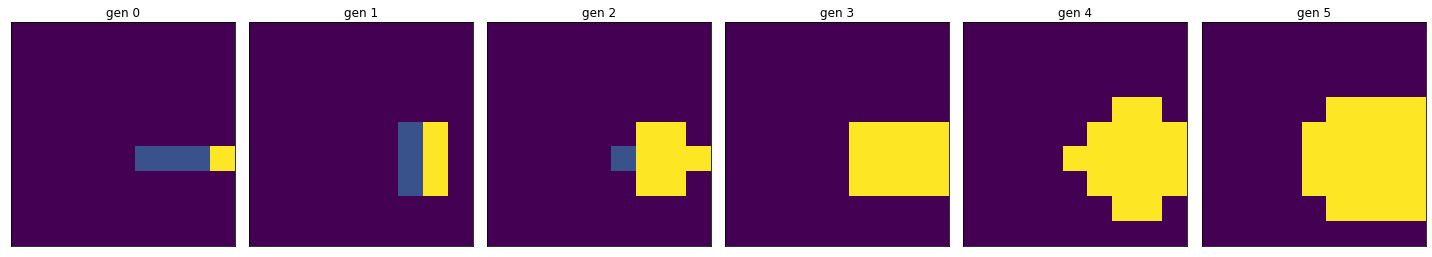

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

# Fixing random state for reproducibility
# np.random.seed(19680801)

# grid = np.random.rand(32, 32)

grid = block_test
print(block_test.tolist())
grid = gen_noisy_block(grid, 0, 0.02)

test_block = np.zeros((9, 9, 6), dtype = np.uint32)
test_block[5,5,0] = 1
test_block[5,6,0] = 1
test_block[5,7,0] = 1
test_block[5,8,0] = 100
grid = test_block
print(grid.tolist())

grid = update_ambigous_block(grid)
grid = grid % 6
layers = grid.shape[2]
print(grid.shape)
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(20, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

t = 0 
for ax, t in zip(axs.flat, range(6)):
    ax.imshow(grid[:,:,t], interpolation=None, cmap='viridis')
    ax.set_title('gen ' + str(t))


plt.tight_layout()
plt.show()

In [ ]:
!pip install python-lifelib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 724 kB 4.7 MB/s 
  Created wheel for python-lifelib: filename=python_lifelib-2.5.5-py3-none-any.whl size=780540 sha256=4fb25ab7acf5dcb65a66ab255272bef0c3fda8f3ba02db67d6c2a6e390b888f5
  Stored in directory: /root/.cache/pip/wheels/ed/25/f9/8c8f7f54396962d11b27917faf68c250945b3a6fe390dad9e1
Successfully built python-lifelib


In [ ]:
#rle_string

import lifelib
sess = lifelib.load_rules("b3s23")
lt = sess.lifetree()
print(lt.pattern('xp5_y4g6q11q6gz0gg08kc321y0123ck80ggz6pg99gy8g99gp6zy0123ck8gwg8kc321zy5658856').rle_string().replace('\n', '').split('rule = B3/S23')[1].replace('A', 'o').replace('.', 'b'))

11b2o$9b2o2b2o$9bo4bo$10bo2bo$8bobo2bobo$7bobo4bobo$7b2o6b2o$5b2o10b2o$4bobo10bobo$b2o2bo12bo2b2o$bob2o14b2obo$o22bo$o22bo$bob2o14b2obo$b2o2bo12bo2b2o$4bobo10bobo$5b2o10b2o$7b2o6b2o$7bobo4bobo$8bobo2bobo$10bo2bo$9bo4bo$9b2o2b2o$11b2o!


In [ ]:
s = set()
lines = []
with open('in_data_p5.txt') as f:
    lines = f.readlines()
lines = [i.replace('\"', '').replace('\n', '').split(',')[0] for i in lines if len(i) > 4 and 'occurrences' not in i]

s = set(lines)
print(len(s))

6021


In [ ]:
import lifelib
sess = lifelib.load_rules("b3s23")
lt = sess.lifetree()
out12 = []

with open('data_p5.txt', 'w') as f:
    for i in sorted(list(s)):
        p = lt.pattern(i).rle_string().replace('\n', '').split('rule = B3/S23')[1].replace('A', 'o').replace('.', 'b')
        out12.append(p)
        f.write(p + '\n')

In [ ]:
import numpy as np

def near(a, b):
    yield (a, b+1)
    yield (a+1, b)
    yield (a, b-1)
    yield (a-1, b)
    yield (a+1, b+1)
    yield (a-1, b+1)
    yield (a+1, b-1)
    yield (a-1, b-1)

def to_points(s):
    out = set()
    for i in range(len(s)):
        for j in range(len(s[0])):
            if s[i][j] == 1: out.add((i,j))
    return out

def get_hull(s):
    out = set()
    for i in s:
        for j in near(*i):
            out.add(j)
    return out - s


def get_new_generation(s):
    new_set = set()
    for i in s:
        c = 0
        for j in near(*i):
            if j in s:
                c+=1
        if c == 2 or c == 3:
            new_set.add(i)

    for i in get_hull(s):
        c = 0
        for j in near(*i):
            if j in s: c+=1
        if c == 3:
            new_set.add(i)
    
    return new_set

def to_arr(points):

    min_x = min(point[0] for point in points)
    max_x = max(point[0] for point in points)

    min_y = min(point[1] for point in points)
    max_y = max(point[1] for point in points)

    min_z = min(point[2] for point in points)
    max_z = max(point[2] for point in points)
    
    #print(min_x,max_x, min_y,max_y, min_z,max_z)

    m = np.zeros((max_x-min_x+1, max_y-min_y+1, max_z-min_z+1), dtype = int)

    for a,b,c in points:
        m[a - min_x,b - min_y,c - min_z] = 1

    return m

def get_block(start_m, gens = 17):
    s = to_points(start_m)
    
    out_points = list()

    for i in range(gens+1):
        out_points.extend(list(map(lambda t: (t[0], t[1], i), s)))
        s = get_new_generation(s)
    print(out_points)
    return to_arr(out_points)

def get_block2(start_m, gens = 5):
    s = to_points(start_m)
    
    out_points = list()

    for i in range(gens):
        out_points.extend(list(map(lambda t: (t[0], t[1], i), s)))
        s = get_new_generation(s)
    #print(out_points)
    arr1 = to_arr(out_points)
    if max(arr1.shape) <= 16:
        return out_points
    else:
        return []

# block_test = get_block(ex_mat, 17)

# print(block_test.shape)
points_for_b = []

for i in out12:
    p = get_block2(from_rle(i))
    if p != []:
        points_for_b.append(i)

print(len(points_for_b))


with open('data_p5_2.txt', 'w') as f:
    for p in sorted(points_for_b, key = lambda k: len(k)):
        #p = lt.pattern(i).rle_string().replace('\n', '').split('rule = B3/S23')[1].replace('A', 'o').replace('.', 'b')
        #out12.append(p)
        f.write(p + '\n')

2237


In [ ]:
points_for_b = sorted(points_for_b, key = lambda k: len(k))
print(points_for_b[444])

4b2o$2o2bo$obobo$b2ob2o2$b5o$bo4bobo2bo$b3o2bob4o$2bobobo$3b2obob2o$4b3obobo$9b2o!
